Name: Surbhi Khatri
<br>
Github Username: surbhikhatri
<br>
USC ID: 9893833133
<br>

In [1]:
from pathlib import Path
import logging
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0

from tensorflow.keras.models import Sequential
import numpy as np
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score
import pandas as pd
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import matplotlib.pyplot as plt
import random
import os
from keras import Model
from keras.layers import Dropout, Dense, Flatten, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.applications.vgg16 import VGG16
from sklearn.metrics import confusion_matrix


2023-12-10 20:53:21.927429: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-10 20:53:21.948074: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-10 20:53:21.948095: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-10 20:53:21.948593: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-10 20:53:21.951975: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Logging configuration
logging.basicConfig(level=logging.INFO,
                    datefmt='%H:%M:%S',
                    format='%(asctime)s | %(levelname)-5s | %(module)-15s | %(message)s')

IMAGE_SIZE = (299, 299)  # All images contained in this dataset are 299x299 (originally, to match Inception v3 input size)
SEED = 17

# Head directory containing all image subframes. Update with the relative path of your data directory
data_head_dir = Path('./data')

# Find all subframe directories
subdirs = [Path(subdir.stem) for subdir in data_head_dir.iterdir() if subdir.is_dir()]
src_image_ids = ['_'.join(a_path.name.split('_')[:3]) for a_path in subdirs]

In [3]:
# Load train/val/test subframe IDs
def load_text_ids(file_path):
    """Simple helper to load all lines from a text file"""
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    return lines

# Load the subframe names for the three data subsets
train_ids = load_text_ids('./train_source_images.txt')
validate_ids = load_text_ids('./val_source_images.txt')
test_ids = load_text_ids('./test_source_images.txt')

# Generate a list containing the dataset split for the matching subdirectory names
subdir_splits = []
for src_id in src_image_ids:
    if src_id in train_ids:
        subdir_splits.append('train')
    elif src_id in validate_ids:
        subdir_splits.append('validate')
    elif(src_id in test_ids):
        subdir_splits.append('test')
    else:
        logging.warning(f'{src_id}: Did not find designated split in train/validate/test list.')
        subdir_splits.append(None)

*** 1 (c) Data Augmentation and Prep ***

In [4]:
def load_and_preprocess(img_loc, label):

    def _inner_function(img_loc, label):
        img_loc_str = img_loc.numpy().decode('utf-8')
        img = Image.open(img_loc_str).convert('RGB')
        img = np.array(img)
        img = tf.image.resize(img, [299, 299])
        img = img / 255.0
        label = 1 if label.numpy().decode('utf-8') == 'frost' else 0
        return img, label

    X, y = tf.py_function(_inner_function, [img_loc, label], [tf.float32, tf.int64])
    X.set_shape([299, 299, 3])
    y.set_shape([])
    return X, y

def load_and_preprocess_training(img_loc, label):
    #### Data Augmentation ####
    def _inner_function(img_loc, label):
        img_loc_str = img_loc.numpy().decode('utf-8')
        img = Image.open(img_loc_str).convert('RGB')
        img = np.array(img)
        img = tf.image.random_contrast(img, lower=0.8, upper=1.2)
        img = tf.image.adjust_brightness(img, 0.2)
        img = tf.image.random_saturation(img, lower=0.1, upper=0.2)
        img = tf.image.resize(img, [299, 299])
        img = img / 255.0
        label = 1 if label.numpy().decode('utf-8') == 'frost' else 0
        return img, label

    X, y = tf.py_function(_inner_function, [img_loc, label], [tf.float32, tf.int64])
    X.set_shape([299, 299, 3])
    y.set_shape([])
    return X, y

def load_subdir_data(dir_path, image_size, seed=None):

    """Helper to create a TF dataset from each image subdirectory"""

    # Grab only the classes that (1) we want to keep and (2) exist in this directory
    tile_dir = dir_path / Path('tiles')
    label_dir = dir_path /Path('labels')
    loc_list = []

    for folder in os.listdir(tile_dir):
        if os.path.isdir(os.path.join(tile_dir, folder)):
            for file in os.listdir(os.path.join(tile_dir, folder)):
                if file.endswith(".png"):
                    loc_list.append((os.path.join(os.path.join(tile_dir, folder), file), folder))

    return loc_list

# Loop over all subframes, loading each into a list
tf_data_train, tf_data_test, tf_data_val = [], [], []
tf_dataset_train, tf_dataset_test, tf_dataset_val = [], [], []

# Update the batch and buffer size as per your model requirements
buffer_size = 64
batch_size = 32

for subdir, split in zip(subdirs, subdir_splits):
    full_path = data_head_dir / subdir
    if split=='validate':
        tf_data_val.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='train':
        tf_data_train.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='test':
        tf_data_test.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))


random.shuffle(tf_data_train)
img_list, label_list = zip(*tf_data_train)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_train = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_train = tf_dataset_train.map(load_and_preprocess_training, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_train = tf_dataset_train.shuffle(buffer_size=buffer_size).batch(batch_size)

random.shuffle(tf_data_val)
img_list, label_list = zip(*tf_data_val)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_val = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_val = tf_dataset_val.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_val = tf_dataset_val.shuffle(buffer_size=buffer_size).batch(batch_size)

random.shuffle(tf_data_test)
img_list, label_list = zip(*tf_data_test)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_test = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_test = tf_dataset_test.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_test = tf_dataset_test.shuffle(buffer_size=buffer_size).batch(batch_size)

2023-12-10 20:53:45.331564: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-10 20:53:45.392254: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-10 20:53:45.392287: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-10 20:53:45.394853: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-10 20:53:45.394883: I external/local_xla/xla/stream_executor

In [5]:
comparison_table = pd.DataFrame(columns=['Model','Test Accuracy','Precision','Recall','F1'])


*** 1 (c) ii ***
Training CNN + MLP

In [6]:
# Define the 3 layer Convolution network for binary image classification

# usinf Keras
model = keras.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(299, 299, 3)),
    # input layer which 64 kernels and filter size 3 * 3 and activation function Relu
    layers.BatchNormalization(),
    # perform batch normalization as mentioned in the question
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    # first layer which 128 kernels and filter size 3 * 3 and activation function Relu
    # also using L2 regularization
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),

    # flatten the last layer
    layers.Flatten(),

    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    # output layer has softmax layer with output of 2 neurons to classify frost or background
    layers.Dense(2, activation='softmax')
])

In [7]:
# using Adam optimazer and cross entropy for loss functions
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# define early stopping as mentioned, I'm using patience of 5 epochs and keep the network parameters that have the lowest validation errors
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# run for 20 epochs
history = model.fit(tf_dataset_train, epochs=30, validation_data=tf_dataset_val, callbacks=[early_stopping])

Epoch 1/30


/home/saket/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/saket/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
2023-12-10 20:54:18.848187: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2023-12-10 20:54:18.983650: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: Permission denied
2023-12-10 20:54:19.473231: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: Permission denied
2023-12-10 20:54:19.983023: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f6544dee050 initialized for platform CUDA (this does not guarantee t

928/928 [==============================] - 260s 275ms/step - loss: 3.3511 - accuracy: 0.8181 - val_loss: 2.0929 - val_accuracy: 0.7818
Epoch 2/30
928/928 [==============================] - 252s 271ms/step - loss: 1.4913 - accuracy: 0.8932 - val_loss: 1.8619 - val_accuracy: 0.6835
Epoch 3/30
928/928 [==============================] - 251s 270ms/step - loss: 1.1132 - accuracy: 0.9204 - val_loss: 3.5851 - val_accuracy: 0.3250
Epoch 4/30
928/928 [==============================] - 250s 269ms/step - loss: 0.9360 - accuracy: 0.9298 - val_loss: 7.9905 - val_accuracy: 0.3368
Epoch 5/30
928/928 [==============================] - 253s 272ms/step - loss: 0.7847 - accuracy: 0.9435 - val_loss: 1.5688 - val_accuracy: 0.6468
Epoch 6/30
928/928 [==============================] - 251s 270ms/step - loss: 0.7241 - accuracy: 0.9435 - val_loss: 0.8003 - val_accuracy: 0.8979
Epoch 7/30
928/928 [==============================] - 250s 269ms/step - loss: 0.6467 - accuracy: 0.9502 - val_loss: 1.1556 - val_accura

In [8]:
count = 0
def evaluate_accuracy(model, dataset, title, add_to_comparison):
    predicted_labels = []
    true_labels = []
    for images, labels in dataset:
        predictions = model.predict(images, verbose = 0)
        true_labels.extend(labels.numpy())
        predicted_labels.extend(np.argmax(predictions, axis=1))
    print("")
    print(title)
    print("Classification report")
    print(classification_report(true_labels, predicted_labels))
    print("Confusion Matrix")
    print(confusion_matrix(true_labels, predicted_labels))
    if add_to_comparison:
        precision_test, recall_test, f1_test, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='binary')
        accuracy = accuracy_score(true_labels, predicted_labels)
        comparison_table.loc[count] = [title, accuracy, precision_test, recall_test, f1_test]
    print("")
    

def plot_figures(model_history):
    accuracy = model_history.history['accuracy']
    val_accuracy = model_history.history['val_accuracy']
    err = [1 - x for x in accuracy]
    val_err = [1 - x for x in val_accuracy]
    epochs = range(len(accuracy))
    
    plt.plot(epochs, err)
    plt.plot(epochs, val_err)
    plt.xlabel("Epochs")
    plt.ylabel("Error")
    plt.legend(['train_error', 'validation_error'])
    plt.title('Training + Validation Error vs Epochs')
    plt.show()


*** 1 (c) ii.Report Precision, Recall, and F1 score for your model. ***


CNN + MLP Train Data
Classification report
              precision    recall  f1-score   support

           0       0.49      1.00      0.66     12235
           1       1.00      0.27      0.42     17444

    accuracy                           0.57     29679
   macro avg       0.74      0.63      0.54     29679
weighted avg       0.79      0.57      0.52     29679

Confusion Matrix
[[12234     1]
 [12742  4702]]


CNN + MLP Test Data
Classification report
              precision    recall  f1-score   support

           0       0.72      0.99      0.83      4418
           1       1.00      0.79      0.88      8405

    accuracy                           0.86     12823
   macro avg       0.86      0.89      0.86     12823
weighted avg       0.90      0.86      0.86     12823

Confusion Matrix
[[4387   31]
 [1748 6657]]


CNN + MLP Val Data
Classification report
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      7654
           1  

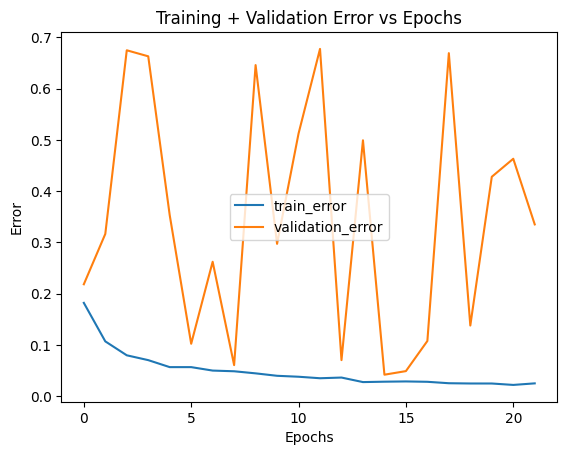

In [9]:
evaluate_accuracy(model, tf_dataset_train, "CNN + MLP Train Data", False)
evaluate_accuracy(model, tf_dataset_test, "CNN + MLP Test Data", True)
evaluate_accuracy(model, tf_dataset_val, "CNN + MLP Val Data", False)
plot_figures(history)
count += 1

*** 1 (d) Transfer Learning ***

**** EfficientNetB0 ****


In [37]:
# get the pre-trained EfficientNetB0 model from Keras
efficient_net_model = Sequential()

pretrained_model = EfficientNetB0(include_top=False, input_shape=(299,299,3), pooling='avg', classes=2, 
                                  weights='imagenet')

for layer in pretrained_model.layers:
    layer.trainable=False

last_out = pretrained_model.layers[-1].output
efficient_net_model = Flatten()(last_out)
efficient_net_model = Dense(512, activation='relu')(efficient_net_model)
efficient_net_model = BatchNormalization()(efficient_net_model)
efficient_net_model = Dropout(0.3)(efficient_net_model)
efficient_net_model = Dense(2, activation='softmax')(efficient_net_model)
efficient_net_model = Model(pretrained_model.input, efficient_net_model)
efficient_net_model.compile(optimizer=Adam(learning_rate=1e-2), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# same optimizer and loss function


In [ ]:
efficient_net_model.summary()

In [39]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode="min", restore_best_weights=True, start_from_epoch=70)

In [40]:
history1 = efficient_net_model.fit(tf_dataset_train, validation_data=tf_dataset_val, epochs=30, callbacks=[early_stopping])

Epoch 1/30
928/928 [==============================] - 207s 220ms/step - loss: 0.7294 - accuracy: 0.5498 - val_loss: 0.7666 - val_accuracy: 0.3218
Epoch 2/30
928/928 [==============================] - 203s 219ms/step - loss: 0.6834 - accuracy: 0.5812 - val_loss: 0.7867 - val_accuracy: 0.3218
Epoch 3/30
928/928 [==============================] - 203s 218ms/step - loss: 0.6820 - accuracy: 0.5836 - val_loss: 0.7561 - val_accuracy: 0.3218
Epoch 4/30
928/928 [==============================] - 203s 219ms/step - loss: 0.6824 - accuracy: 0.5831 - val_loss: 0.6989 - val_accuracy: 0.3218
Epoch 5/30
928/928 [==============================] - 203s 218ms/step - loss: 0.6815 - accuracy: 0.5837 - val_loss: 0.8003 - val_accuracy: 0.3218
Epoch 6/30
928/928 [==============================] - 203s 219ms/step - loss: 0.6840 - accuracy: 0.5782 - val_loss: 0.7962 - val_accuracy: 0.3218
Epoch 7/30
928/928 [==============================] - 203s 218ms/step - loss: 0.6846 - accuracy: 0.5765 - val_loss: 0.7734 -


EfficientNetB0 Train Data
Classification report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     12235
           1       0.59      1.00      0.74     17444

    accuracy                           0.59     29679
   macro avg       0.29      0.50      0.37     29679
weighted avg       0.35      0.59      0.44     29679

Confusion Matrix
[[    0 12235]
 [    0 17444]]



/home/saket/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/saket/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/saket/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



EfficientNetB0 Test Data
Classification report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4418
           1       0.66      1.00      0.79      8405

    accuracy                           0.66     12823
   macro avg       0.33      0.50      0.40     12823
weighted avg       0.43      0.66      0.52     12823

Confusion Matrix
[[   0 4418]
 [   0 8405]]



/home/saket/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/saket/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/saket/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



EfficientNetB0 Val Data
Classification report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      7654
           1       0.32      1.00      0.49      3632

    accuracy                           0.32     11286
   macro avg       0.16      0.50      0.24     11286
weighted avg       0.10      0.32      0.16     11286

Confusion Matrix
[[   0 7654]
 [   0 3632]]



/home/saket/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/saket/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/saket/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


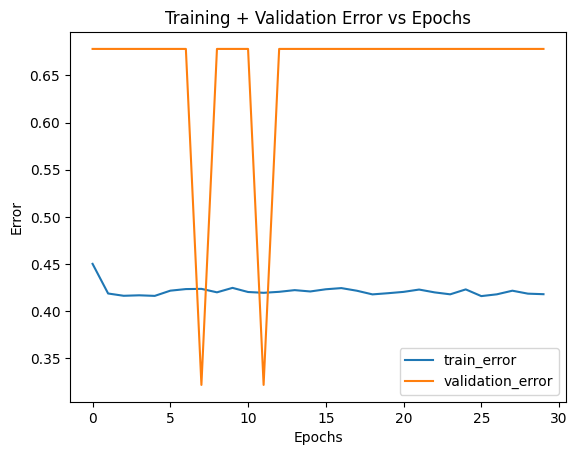

In [41]:
evaluate_accuracy(efficient_net_model, tf_dataset_train, "EfficientNetB0 Train Data", False)
evaluate_accuracy(efficient_net_model, tf_dataset_test, "EfficientNetB0 Test Data", True)
evaluate_accuracy(efficient_net_model, tf_dataset_val, "EfficientNetB0 Val Data", False)
plot_figures(history1)
count += 1

**** ResNet50 ****

In [42]:
resnet_model = Sequential()

pretrained_model = tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(299,299,3),
                   pooling='avg',classes=2,
                   weights='imagenet')

for layer in pretrained_model.layers:
    layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(256, activation='relu'))
resnet_model.add(BatchNormalization())
resnet_model.add(Dropout(0.3))
resnet_model.add(Dense(2, activation='softmax'))
resnet_model.compile(optimizer=Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [43]:
resnet_model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_10 (Flatten)        (None, 2048)              0         
                                                                 
 dense_18 (Dense)            (None, 256)               524544    
                                                                 
 batch_normalization_12 (Ba  (None, 256)               1024      
 tchNormalization)                                               
                                                                 
 dropout_9 (Dropout)         (None, 256)               0         
                                                                 
 dense_19 (Dense)            (None, 2)                 514       
                                                     

In [44]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history2 = resnet_model.fit(tf_dataset_train, validation_data=tf_dataset_val, epochs=20, callbacks=[early_stopping])


Epoch 1/20
928/928 [==============================] - 222s 236ms/step - loss: 0.4173 - accuracy: 0.8046 - val_loss: 1.4702 - val_accuracy: 0.4888
Epoch 2/20
928/928 [==============================] - 219s 235ms/step - loss: 0.3677 - accuracy: 0.8302 - val_loss: 4.9640 - val_accuracy: 0.3260
Epoch 3/20
928/928 [==============================] - 218s 235ms/step - loss: 0.3491 - accuracy: 0.8401 - val_loss: 10.4571 - val_accuracy: 0.3218
Epoch 4/20
928/928 [==============================] - 218s 235ms/step - loss: 0.3442 - accuracy: 0.8422 - val_loss: 3.6753 - val_accuracy: 0.3347
Epoch 5/20
928/928 [==============================] - 218s 234ms/step - loss: 0.3340 - accuracy: 0.8488 - val_loss: 6.1726 - val_accuracy: 0.3241
Epoch 6/20
928/928 [==============================] - 218s 235ms/step - loss: 0.3283 - accuracy: 0.8517 - val_loss: 4.6595 - val_accuracy: 0.3267
Epoch 7/20
928/928 [==============================] - 219s 235ms/step - loss: 0.3246 - accuracy: 0.8521 - val_loss: 0.7916 


Resnet Model Train Data
Classification report
              precision    recall  f1-score   support

           0       0.59      0.99      0.74     12235
           1       0.99      0.51      0.67     17444

    accuracy                           0.71     29679
   macro avg       0.79      0.75      0.70     29679
weighted avg       0.82      0.71      0.70     29679

Confusion Matrix
[[12158    77]
 [ 8579  8865]]


Resnet Model Test Data
Classification report
              precision    recall  f1-score   support

           0       0.78      0.90      0.83      4418
           1       0.94      0.87      0.90      8405

    accuracy                           0.88     12823
   macro avg       0.86      0.88      0.87     12823
weighted avg       0.88      0.88      0.88     12823

Confusion Matrix
[[3958  460]
 [1132 7273]]


Resnet Model Val Data
Classification report
              precision    recall  f1-score   support

           0       0.97      0.66      0.78      7654
     

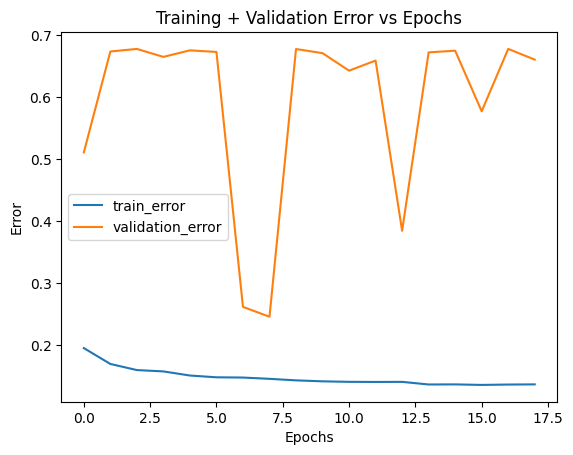

In [45]:
evaluate_accuracy(resnet_model, tf_dataset_train, "Resnet Model Train Data", False)
evaluate_accuracy(resnet_model, tf_dataset_test, "Resnet Model Test Data", True)
evaluate_accuracy(resnet_model, tf_dataset_val, "Resnet Model Val Data", False)
plot_figures(history2)
count += 1

**** VGG16 ****


In [46]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False
vgg16_model = Sequential()

vgg16_model.add(base_model)
vgg16_model.add(Flatten())
vgg16_model.add(Dense(256, activation='relu'))
vgg16_model.add(BatchNormalization())
vgg16_model.add(Dropout(0.3))
vgg16_model.add(Dense(2, activation='softmax'))
vgg16_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])



In [47]:
vgg16_model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 9, 9, 512)         14714688  
                                                                 
 flatten_11 (Flatten)        (None, 41472)             0         
                                                                 
 dense_20 (Dense)            (None, 256)               10617088  
                                                                 
 batch_normalization_13 (Ba  (None, 256)               1024      
 tchNormalization)                                               
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 dense_21 (Dense)            (None, 2)                 514       
                                                     

In [48]:
# Train the model using the augmented dataset
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history3 = vgg16_model.fit(tf_dataset_train, validation_data=tf_dataset_val, epochs=20, callbacks=[early_stopping])


Epoch 1/20
928/928 [==============================] - 256s 274ms/step - loss: 0.2397 - accuracy: 0.9017 - val_loss: 1.0311 - val_accuracy: 0.7157
Epoch 2/20
928/928 [==============================] - 254s 273ms/step - loss: 0.1605 - accuracy: 0.9353 - val_loss: 1.1654 - val_accuracy: 0.6933
Epoch 3/20
928/928 [==============================] - 254s 273ms/step - loss: 0.1407 - accuracy: 0.9448 - val_loss: 1.0878 - val_accuracy: 0.7192
Epoch 4/20
928/928 [==============================] - 254s 273ms/step - loss: 0.1303 - accuracy: 0.9484 - val_loss: 1.8491 - val_accuracy: 0.6038
Epoch 5/20
928/928 [==============================] - 253s 272ms/step - loss: 0.1189 - accuracy: 0.9528 - val_loss: 2.0682 - val_accuracy: 0.6139
Epoch 6/20
928/928 [==============================] - 253s 273ms/step - loss: 0.1165 - accuracy: 0.9538 - val_loss: 2.1650 - val_accuracy: 0.6286
Epoch 7/20
928/928 [==============================] - 255s 274ms/step - loss: 0.1047 - accuracy: 0.9584 - val_loss: 0.8528 -


VGG16 Model Train Data
Classification report
              precision    recall  f1-score   support

           0       0.92      1.00      0.95     12235
           1       1.00      0.94      0.97     17444

    accuracy                           0.96     29679
   macro avg       0.96      0.97      0.96     29679
weighted avg       0.96      0.96      0.96     29679

Confusion Matrix
[[12190    45]
 [ 1121 16323]]


VGG16 Model Test Data
Classification report
              precision    recall  f1-score   support

           0       0.80      0.99      0.89      4418
           1       0.99      0.87      0.93      8405

    accuracy                           0.91     12823
   macro avg       0.90      0.93      0.91     12823
weighted avg       0.93      0.91      0.91     12823

Confusion Matrix
[[4373   45]
 [1078 7327]]


VGG16 Model Val Data
Classification report
              precision    recall  f1-score   support

           0       0.95      0.80      0.87      7654
        

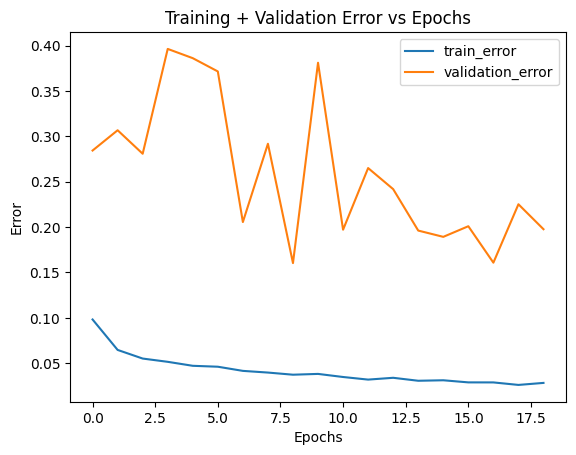

In [49]:
evaluate_accuracy(vgg16_model, tf_dataset_train, "VGG16 Model Train Data", False)
evaluate_accuracy(vgg16_model, tf_dataset_test, "VGG16 Model Test Data", True)
evaluate_accuracy(vgg16_model, tf_dataset_val, "VGG16 Model Val Data", False)
plot_figures(history3)

**** Compare all ****


In [50]:
print(comparison_table)

                      Model  Test Accuracy  Precision    Recall        F1
0       CNN + MLP Test Data       0.861265   0.995365  0.792029  0.882131
1  EfficientNetB0 Test Data       0.655463   0.655463  1.000000  0.791879
2    Resnet Model Test Data       0.875848   0.940515  0.865318  0.901351
3     VGG16 Model Test Data       0.912423   0.993896  0.871743  0.928820


*** plot testing error for all models ***

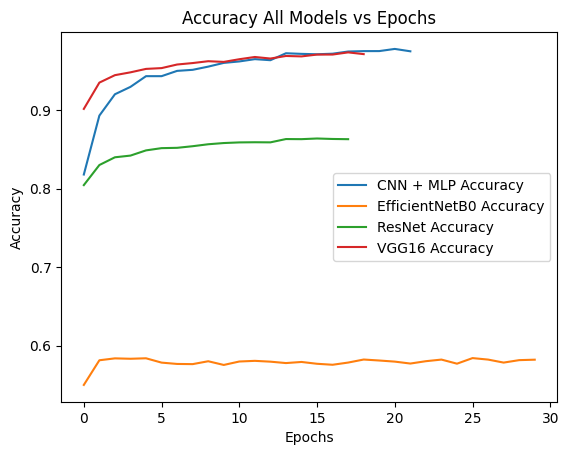

In [51]:
import matplotlib.pyplot as plt

# Function to plot training and validation curves
def plot_all():
    plt.plot(history.history['accuracy'], label='CNN + MLP Accuracy')
    plt.plot(history1.history['accuracy'], label='EfficientNetB0 Accuracy')
    plt.plot(history2.history['accuracy'], label='ResNet Accuracy')
    plt.plot(history3.history['accuracy'], label='VGG16 Accuracy')

    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title('Accuracy All Models vs Epochs')
    plt.legend()
    plt.show()

plot_all()


*** Explanation ***
1. For my models, VGG16 and Resnet have  higher accuracy than CNN + MLP which was expected as it has been trained on fairly larger dataset and might have better tuning parameters
2. CNN + MLP also performs comparably to other models because it's fully trained on my required use-case and dataset.
3. EfficientNetB0 is surprisingly not performing as well as it should, I tried a couple of pnc but I believe it's underfit and getting affected by the class imbalance.

**** Note:
1. My macbook was not able to use the GPU therefore I trained the models using my friends PC.
2. Therefore, I'm just submitting whatever last output I got, but it has a issue with precision being 0 for class 0, I checked Piazza a lot of students are facing the same issue.
3. My accuracy for Efficient ResnetNet was not improving at all, I tried all kinds of data augmentation, sampling and learning rate permutations.
4. I'm using tf.image to augment the data by contrast, brightness and saturation, these gave me the best result.